In [2]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex

In [3]:
try: # Desktop
    import pynrc
    from pynrc import nrc_utils
    from pynrc.nrc_utils import (webbpsf, poppy, pix_noise)
except ImportError: # Laptop
    import sys
    sys.path.insert(0, '/Users/jarron/Dropbox/NIRCam/')

    import pyNRC as pynrc
    from pyNRC import nrc_utils
    from pyNRC.nrc_utils import (webbpsf, poppy, pix_noise)
                       
    poppy.conf.use_multiprocessing=False
    
import astropy.io.fits as fits
import multiprocessing as mp

In [4]:
pynrc.setup_logging('WARNING', verbose=False)

In [5]:
data_path = webbpsf.utils.get_webbpsf_data_path() + '/'
opd_path = data_path + 'NIRCam/OPD/'
opd_file = 'OPD_RevV_nircam_132.fits'
opds, header = fits.getdata(opd_path + opd_file, header=True)

In [6]:
nopd = opds.shape[0]
nproc = int(np.min([nopd,mp.cpu_count()*0.75]))

In [8]:
from poppy import zernike
from poppy.optics import MultiHexagonAperture
from poppy.utils import pad_to_size

class OPD_extract(object):
    
    def __init__(self, opd, header, verbose=False):

        self.opd = opd
        self.npix = opd.shape[0]
        self.pix_scale = header['PUPLSCAL'] # pupil scale in meters/pixel

        # Create a list of segment masks
        self.nseg = 18
        # Flat to flat is 1.32 meters with a 3 mm air gain between mirrors
        # Supposedly there's a 15 mm effective gap due to polishing
        f2f = 1.308
        gap = 0.015

        # Analytic pupil mask for all segments
        # To work with the OPD Rev V masks, use npix=1016 and pad to 1024
        self._mask_pupil = MultiHexagonAperture(rings=2, flattoflat=f2f, gap=gap)

        # Individual segments in a list
        self._mask_segs = []
        for i in np.arange(self.nseg)+1:
            self._mask_segs.append(MultiHexagonAperture(rings=2, flattoflat=f2f, gap=gap, segmentlist=[i]))
        
        # Get the x/y positions 
        self.segment_positions = [self._get_seg_xy(i) for i in range(self.nseg)]
        
        self.basis_zernike = zernike.zernike_basis_faster
        self.basis_hexike  = zernike.hexike_basis
        
        if verbose: print('Fitting Zernike coefficients for entire pupil...')
        self._coeff_pupil = self._get_coeff_pupil()
        if verbose: print('Constructing OPD from entire pupil coefficients...')
        self.opd_new_pupil = self._get_opd_pupil()
        self.opd_diff_pupil = self.opd - self.opd_new_pupil

        if verbose: print('Fitting Hexike coefficients for each segment...')
        self._coeff_segs = self._get_coeff_segs()
        if verbose: print('Constructing OPD for each segment...')
        self.opd_new_segs = self._get_opd_new_segs()

        print('Finished.')

    @property
    def mask_pupil(self):
        outmask, _ = self._sample_mask(self._mask_pupil)
        return outmask
    
    @property
    def mask_opd(self):
        mask = np.ones(self.opd.shape)
        mask[self.opd==0] = 0
        return mask
    
    @property
    def coeff_pupil(self):
        return self._coeff_pupil

    @property
    def coeff_segs(self):
        """Hexike coefficients for a given segment index"""
        return self._coeff_segs
    
    def mask_seg(self, i):
        """Return a sampled subsection of the analytic segment mask"""
        # Mask off everything but the segment of interest
        pmask = self._mask_segs[i]
        outmask, _ = self._sample_mask(pmask)
        # Multiply by larger OPD pupil mask
        outmask *= self.mask_opd

        return self.opd_seg(i,outmask)

    def opd_seg(self, i, opd_pupil=None):
        """Return a subsection of some OPD image for the provided segment index"""
        if opd_pupil is None: opd_pupil = self.opd_diff_pupil
        
        # Subsection the image, then pad to equal xy size
        x1,x2,y1,y2 = self.segment_positions[i]
        imsub = opd_pupil[y1:y2,x1:x2]
        
        (ny,nx) = imsub.shape
        npix_max = np.max(imsub.shape)
        
        # Make x and y the same size
        imsub = pad_to_size(imsub, [npix_max,npix_max])
        
        # If nx was larger than ny, then center y
        if nx > ny: # xhift in y
            shift = (ny-nx)//2 if y1>0 else (nx-ny)//2
            imsub = np.roll(imsub, shift, axis=0)
        elif ny > nx: # shift in x
            shift = (nx-ny)//2 if x1>0 else (ny-nx)//2
            imsub = np.roll(imsub, shift, axis=1)
        
        return imsub

    def _get_coeff_pupil(self):
        """Calculate Zernike coefficients for full OPD"""
        return self._get_coeff(self.opd, self.mask_opd, self.basis_zernike, iterations=2)

    def _get_opd_pupil(self):
        """Generate OPD for entire pupil based on coefficients"""
        opd = self._opd_from_coeff(self.coeff_pupil, self.basis_zernike, self.mask_pupil)
        return opd * self.mask_opd
    
    def _get_coeff_segs(self, opd_pupil=None):
        """Calculate Hexike coeffiencts each individual segment"""
        coeff_list = []
        for i in range(self.nseg): #, pmask in enumerate(self._mask_segs):
            mask_sub = self.mask_seg(i)
            opd_sub  = self.opd_seg(i, opd_pupil)
            
            coeff = self._get_coeff(opd_sub, mask_sub, self.basis_hexike, nterms=30)
            coeff_list.append(coeff)
        return coeff_list
    
    def _get_opd_new_segs(self, coeff_segs=None):
        """Generate segment OPDs in a list"""
        if coeff_segs is None: coeff_segs = self.coeff_segs
        
        opd_list = []
        for i, pmask in enumerate(self._mask_segs):
            mask_sub = self.mask_seg(i)

            opd = self._opd_from_coeff(coeff_segs[i], self.basis_hexike, mask_sub)
            opd *= mask_sub
            opd_list.append(opd)
            
        return opd_list

    def combine_opd_segs(self, opd_segs=None):
        """Combine list of OPD segments into a single image"""
        if opd_segs is None: opd_segs = self.opd_new_segs
        
        opd = np.zeros(self.opd.shape)
        for i, opd_sub in enumerate(opd_segs):
            pmask = self._mask_segs[i]
            mask, _ = self._sample_mask(pmask)
            mask *= self.mask_opd
    
            opd[mask==1] = opd_sub[opd_sub!=0]
            
        return opd
    
    def _get_coeff(self, opd, mask, basis, **kwargs):
        return zernike.opd_expand_nonorthonormal(opd, mask, basis=basis, **kwargs)
    
    def _opd_from_coeff(self, coeff, basis, mask):
        """Generate OPD image from a set of coefficients, basis function, and mask"""
        npix = mask.shape[0]
        return zernike.opd_from_zernikes(coeff, basis=basis, npix=npix, outside=0)
            
    def _sample_mask(self, mask):
        """Sample an analytic pupil mask at 1024x1024"""
        npix = self.npix
        outmask, pixelscale = mask.sample(npix=npix-8, return_scale=True)
        outmask = pad_to_size(outmask, [npix,npix])

        return outmask, pixelscale

    def _get_seg_xy(self, i):
        """
        Get the xy pixel indices (range) of a particular segment mask.
        Returns (x1,x2,y1,y2)
        """
        pmask = self._mask_segs[i]
        outmask, pixelscale = self._sample_mask(pmask)

        pix_rad = np.int(np.ceil(((pmask.side+pmask.gap) / pixelscale).value))
        pix_cen = pmask._hex_center(i+1)
        xc = pix_cen[1] / pixelscale.value + outmask.shape[1] / 2
        yc = pix_cen[0] / pixelscale.value + outmask.shape[0] / 2

        # Grab the pixel ranges
        x1 = np.int(xc - pix_rad)
        x2 = x1 + 2*pix_rad
        y1 = np.int(yc - pix_rad)
        y2 = y1 + 2*pix_rad
        
        # Limits on x/y positions
        x1 = np.max([x1,0])
        x2 = np.min([x2,self.npix])
        y1 = np.max([y1,0])
        y2 = np.min([y2,self.npix])

        return (x1,x2,y1,y2)


In [9]:
# Multiprocessing or each OPD
def opd_extract_helper(args):
    return OPD_extract(args[0], args[1], verbose=False)

pool = mp.Pool(nproc)
worker_arguments = [(opds[i,:,:],header) for i in range(nopd)]
%time opds_all = pool.map(opd_extract_helper, worker_arguments)
pool.close()

Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
CPU times: user 1.67 s, sys: 3.6 s, total: 5.27 s
Wall time: 54.7 s


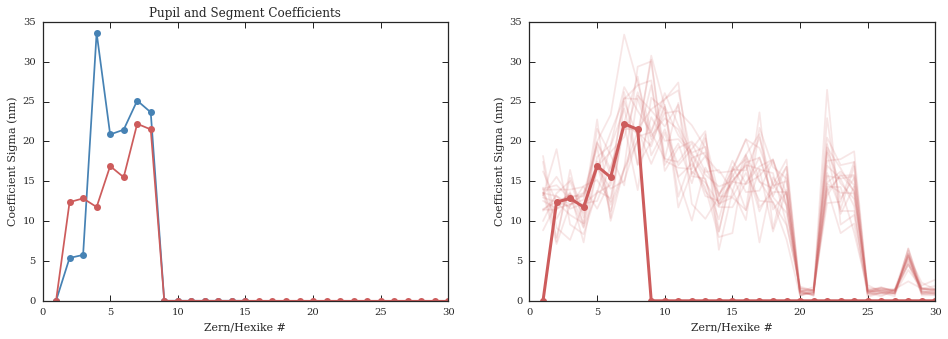

In [10]:
# For the pupil OPD and each segment OPD, find the stdev of each Zern/Hexike coefficient
pup_cf_std = np.array([opds_all[i].coeff_pupil for i in range(9)]).std(axis=0)

nseg = 18
seg_cf_std_all = []
for j in range(nseg):
    std = np.array([opds_all[i].coeff_segs[j] for i in range(9)]).std(axis=0)
    seg_cf_std_all.append(std)
seg_cf_std = np.median(seg_cf_std_all, axis=0)

# These values will be used to vary RMS WFE
# Set the piston values to 0
pup_cf_std[0] = 0.0
seg_cf_std[0] = 0.0

# Zern/Hexikes to vary: 
#   tip, tilt, defocus, 
#   oblique_astigmatism, vertical_astigmatism,
#   vertical_coma, horizontal_coma
# These are Z = 2-8 (indices 1-7)
pup_cf_std[8:] = 0
seg_cf_std[8:] = 0

znum_pup = np.arange(len(pup_cf_std))+1
znum_seg = np.arange(len(seg_cf_std))+1

f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(znum_pup, pup_cf_std*1000, color='steelblue', marker='o')
ax1.plot(znum_seg, seg_cf_std*1000, color='indianred', marker='o')
ax1.set_title('Pupil and Segment Coefficients')

for seg in seg_cf_std_all: 
    ax2.plot(znum_seg, seg*1000, color='indianred', alpha=0.15)
ax2.plot(znum_seg, seg_cf_std*1000, color='indianred', marker='o', lw=3)

for ax in (ax1,ax2):
    ax.set_xlabel('Zern/Hexike #')
    ax.set_ylabel('Coefficient Sigma (nm)')

In [11]:
# Each Zern/Hexike component will get some portion of the total wfe_drift
# Decide based on the variance
#pup_var = pup_cf_std**2
#seg_var = seg_cf_std**2
#all_var = np.array(pup_var.tolist() + seg_var.tolist())

#delta_var = ((wfe_drift/1000)**2) * all_var/all_var.sum()
#delta_coeff = np.sqrt(delta_var)

#print(seg_cf_std.sum())

#f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
#ax1.plot(pup_cf_std*1000)
#ax1.plot(seg_cf_std*1000)

#ax2.plot(delta_coeff[:pup_var.size]*1000)
#ax2.plot(delta_coeff[pup_var.size:]*1000)
#ax2.set_xlabel('Coefficient #')
#ax2.set_ylabel('Coefficient Drift (nm)')

In [12]:
#opd_object = opds_all[0] #OPD_extract(opds[0],header)

In [13]:
def opd_sci_gen(opd):
    """Function to go through an OPD class and generate a sci OPD image"""
    mask_pupil = opd.mask_pupil * opd.mask_opd
    opd_pupil  = opd.opd_new_pupil * mask_pupil
    opd_segs   = opd.combine_opd_segs(opd.opd_new_segs) * mask_pupil
    opd_resid  = (opd.opd - (opd_pupil+opd_segs)) * mask_pupil

    # OPD for science target observation
    opd_sci = opd_pupil + opd_segs + opd_resid
    
    # Return the residuals for use in drifted
    return (opd_sci, opd_resid)

In [56]:
def opd_ref_gen(args, verbose=False, case=1):
    """Generate a drifted OPD image"""
    opd, wfe_drift, pup_cf_std, seg_cf_std, opd_resid = args
    np.random.seed()

    # Pupil mask (incl. segment spaces and secondary struts)
    mask_pupil = opd.mask_pupil * opd.mask_opd

    # Case of Pupil Only
    if case==1:
        var = pup_cf_std**2
        std = np.sqrt(var/var.sum()) * (wfe_drift/1000)
        rand = np.random.randn(std.size) * std
        coeff_pupil_new = opd.coeff_pupil + rand #delta_coeff[:pup_var.size]
        ncf = pup_cf_std[pup_cf_std!=0].size

        opd_pupil_new = opd._opd_from_coeff(coeff_pupil_new, opd.basis_zernike, mask_pupil) * mask_pupil
        opd_segs_new  = opd.combine_opd_segs(opd.opd_new_segs) * mask_pupil

        # Total
        opd_sci = opd.opd * mask_pupil
        opd_ref = opd_pupil_new + opd_segs_new + opd_resid

        # Take the difference and make sure the RMS WFE difference is correct
        # Add this to the overall pupil coefficients
        opd_diff = (opd_sci - opd_ref) * mask_pupil
        rms_diff = opd_diff[opd_diff!=0].std()
        delta_rms = wfe_drift/1000 - rms_diff
        ind = var>0
        coeff_pupil_new[ind] += 1.1 * delta_rms * (rand[ind]/np.abs(rand[ind])) / np.sqrt(var[ind].size)
        opd_pupil_new = opd._opd_from_coeff(coeff_pupil_new, opd.basis_zernike, mask_pupil) * mask_pupil

        opd_ref = opd_pupil_new + opd_segs_new + opd_resid
        
    # Case of Segments Only
    elif case==2:
        opd_pupil_new = opd.opd_new_pupil # No drift to overall pupil
 
        # Segments
        # Random Gaussian noise distributed across each Zernike coeff
        rand_all = []
        coeff_segs_new = []
        var = seg_cf_std**2
        std = np.sqrt(var/var.sum()) * (wfe_drift/1000)
        for cf in opd.coeff_segs:
            rand = np.random.randn(std.size) * std
            rand_all.append(rand)
            coeff_segs_new.append(cf + rand)

        opd_segs_new_list = opd._get_opd_new_segs(coeff_segs_new)
        opd_segs_new = opd.combine_opd_segs(opd_segs_new_list) * mask_pupil

        # Total
        opd_sci = opd.opd * mask_pupil
        opd_ref = opd_pupil_new + opd_segs_new + opd_resid
        
        # Take the difference and make sure the RMS WFE difference is correct
        opd_diff = (opd_sci - opd_ref) * mask_pupil
        # Add this to the overall segment coefficients
        rms_diff = opd_diff[opd_diff!=0].std()
        delta_rms = wfe_drift/1000 - rms_diff
        ind = var>0; nind = var[ind].size
        for i,cf in enumerate(coeff_segs_new):
            rand = rand_all[i]
            cf[ind] += delta_rms * (rand[ind]/np.abs(rand[ind])) / np.sqrt(nind)
        opd_segs_new_list = opd._get_opd_new_segs(coeff_segs_new)
        opd_segs_new = opd.combine_opd_segs(opd_segs_new_list) * mask_pupil

        opd_ref = opd_pupil_new + opd_segs_new + opd_resid
        
    # Case of Pupil and Segments distributed evenly
    elif case==3:
        # Pupil
        var = pup_cf_std**2
        std = np.sqrt(var/var.sum()) * (wfe_drift/1000)
        rand_pup = np.random.randn(std.size) * std / np.sqrt(2.0)
        coeff_pupil_new = opd.coeff_pupil + rand_pup #delta_coeff[:pup_var.size]
        opd_pupil_new = opd._opd_from_coeff(coeff_pupil_new, opd.basis_zernike, mask_pupil) * mask_pupil

        # Segments
        # Random Gaussian noise distributed across each Zernike coeff
        coeff_segs_new = []
        var = seg_cf_std**2
        std = np.sqrt(var/var.sum()) * (wfe_drift/1000) / np.sqrt(2.0)
        for cf in opd.coeff_segs:
            rand = np.random.randn(std.size) * std
            coeff_segs_new.append(cf + rand)

        #coeff_segs_new = [cf + np.random.normal(0,wfe_drift/1000,cf.shape) for cf in opd.coeff_segs]
        opd_segs_new_list = opd._get_opd_new_segs(coeff_segs_new)
        opd_segs_new = opd.combine_opd_segs(opd_segs_new_list) * mask_pupil


        # Total
        opd_sci = opd.opd * mask_pupil
        opd_ref = opd_pupil_new + opd_segs_new + opd_resid

        # Take the difference and make sure the RMS WFE difference is correct
        # Add this to the overall pupil coefficients
        opd_diff = (opd_sci - opd_ref) * mask_pupil
        rms_diff = opd_diff[opd_diff!=0].std()
        delta_rms = wfe_drift/1000 - rms_diff
        ind = (pup_cf_std**2)>0; nind = rand_pup[ind].size
        coeff_pupil_new[ind] += 1.1 * delta_rms * (rand_pup[ind]/np.abs(rand_pup[ind])) / np.sqrt(nind)
        #coeff_pupil_new += delta_rms
        #coeff_pupil_new[pup_cf_std!=0] -= delta_rms
        opd_pupil_new = opd._opd_from_coeff(coeff_pupil_new, opd.basis_zernike, mask_pupil) * mask_pupil

        opd_ref = opd_pupil_new + opd_segs_new + opd_resid
        
    # Jeremy's Method
    elif case==4:
        opd_sci = opd.opd * mask_pupil
        opd_ref = opd_drift_nogood(opd_sci, wfe_drift) * mask_pupil
        
    
    if verbose:
        opd_sci = opd.opd * mask_pupil
        opd_diff = (opd_sci - opd_ref) * mask_pupil
        print('Sci RMS: {:.3f}, Ref RMS: {:.3f}, RMS diff: {:.4f}' \
              .format(opd_sci[opd_sci!=0].std(), opd_ref[opd_ref!=0].std(), opd_diff[opd_diff!=0].std()))
    
    return opd_ref

In [15]:
# Function to drift a list of  OPDs 
def ODP_drift_all(wfe_drift, opds_all, pup_cf_std, seg_cf_std, opd_resid_list):
    """
    Drift a list of OPDs by some RMS WFE (multiprocess function)

    Args:
        opds_all - List of OPD objects
        wfe_drift - In nm
        pup_cf_std - Zernike sigma for overall pupil
        seg_cf_std - Hexike sigma for segments
        opd_resid_list - List of residual images (from opd_sci_gen) for each OPD
    """
    #opds_all, wfe_drift, pup_cf_std, seg_cf_std, opd_resid_list = args

    nopd = len(opds_all)
    nproc = int(np.min([nopd,mp.cpu_count()*0.75]))

    pool = mp.Pool(nproc)
    worker_arguments = [(opds_all[i], wfe_drift, pup_cf_std, seg_cf_std, opd_resid_list[i]) for i in range(nopd)]
    out = pool.map(opd_ref_gen, worker_arguments)
    pool.close()
    pool.join()
    
    print('Finished: {:.0f} nm'.format(wfe_drift))

    return out

In [75]:
def get_psf_sci(opd_sci, filter='F410M', mask=None, pupil=None):
    
    # Convert OPD to HDU list for use in WebbPSF
    hdu1 = fits.PrimaryHDU(opd_sci)
    hdu1.header = header.copy()
    opd_sci_hdulist = fits.HDUList([hdu1])
    
    # Planet PSF
    nc0 = webbpsf.NIRCam()
    nc0.pupilopd = opd_sci_hdulist
    nc0.filter     = filter
    nc0.image_mask = None
    nc0.pupil_mask = pupil
    #if mask is None:
    #    nc0.options['jitter'] = 'gaussian'
    #    nc0.options['jitter_sigma'] = 0.01
    
    psf0 = nc0.calc_psf(fov_arcsec=10)
    if mask is None: return psf0, psf0

    # Stellar PSF
    nc1 = webbpsf.NIRCam()
    nc1.filter     = filter
    nc1.image_mask = mask
    nc1.pupil_mask = pupil
    nc1.pupilopd   = opd_sci_hdulist
    psf1 = nc1.calc_psf(fov_arcsec=10)
    
    return psf0, psf1
    
def get_psf_ref(opd_ref, filter='F410M', mask=None, pupil=None):
    hdu2 = fits.PrimaryHDU(opd_ref)
    hdu2.header = header.copy()
    opd_ref_hdulist = fits.HDUList([hdu2])    

    # Reference PSF
    nc2 = webbpsf.NIRCam()
    nc2.filter     = filter
    nc2.image_mask = mask
    nc2.pupil_mask = pupil
    nc2.pupilopd   = opd_ref_hdulist
    
    #if mask is None:
    #    nc2.options['jitter'] = 'gaussian'
    #    nc2.options['jitter_sigma'] = 0.01
        
    return nc2.calc_psf(fov_arcsec=10)
    
def get_contrast(psf0,psf1,psf2):
    """
    For science and reference PSFs, return the contrast curve.
    Assumes no noise other than residual speckle noise.
    psf0 is the planet PSF
    psf1 is the stellar PSF
    psf2 is the reference PSF
    """

    # PSF subtraction
    from copy import deepcopy
    psf_diff = deepcopy(psf1)
    psf_diff[0].data = (psf1[0].data - psf2[0].data)
    psf_diff[1].data = (psf1[1].data - psf2[1].data)

    # Radial noise profiles of PSF difference
    rr0, stds0 = webbpsf.radial_profile(psf_diff, ext=0, stddev=True)
    #rr1, stds1 = webbpsf.radial_profile(psf_diff, ext=1, stddev=True)

    ## Total planet signal at a radius of 0.5"
    #rr_psf0, mn_psf0, ee_psf0 = webbpsf.radial_profile(psf0, ext=0, EE=True)
    #rad_asec = 0.5
    #npix = np.pi * (rad_asec / psf0[0].header['PIXELSCL'])**2
    ## Get the encircled energy of planet at radius
    #planet_signal = np.interp(rad_asec, rr_psf0, ee_psf0)
    ## nsigma of planet signal relative to noise
    #contrast =  np.sqrt(stds0**2 * npix) / planet_signal

    contrast = stds0 / np.max(psf0[0].data)

    return rr0, contrast

In [17]:
def contrast_drift(wfe_drift, psf_sci_all, filter, mask, pupil, opd_ref_list=None, *args):
    """
    Perform WFE drifts on a series of OPDs
    """
    
    if opd_ref_list is None:
        print('Generating opd_ref_list')
        opd_ref_list = ODP_drift_all(wfe_drift, *args)
        
    psf_ref_all = [get_psf_ref(opd, filter, mask, pupil) for opd in opd_ref_list]
    print('Finished: {:.0f} nm'.format(wfe_drift))
    
    return [get_contrast(psf_sci_all[i][0],psf_sci_all[i][1],psf_ref_all[i]) for i in range(nopd)]

In [69]:
def opd_drift_nogood(opd, drift, nterms=8, defocus_frac=0.8):
    """
    Add some WFE drift (in nm) to an OPD image.
    
    Parameters
    ------------
    opd    : OPD images (can be an array of images).
    header : Header file
    drift  : WFE drift in nm

    Returns
    --------
    Returns an HDUList, which can be passed to webbpsf
    """
    

    # Various header info for coordinate grid
    diam  = 6.55118110236
    pix_m = 0.00639763779528
    wfe_rm = 132.
    
    # Create x/y carteesian grid
    sh = opd.shape
    if len(sh) == 3: 
        nz,ny,nx = sh
        opd_sum = opd.sum(axis=0)
        mask0 = (opd_sum == 0)
        mask1 = (opd_sum != 0)
    else:
        nz = 1
        ny,nx = sh
        # Masks for those values equal (and not) to 0
        mask0 = (opd == 0)
        mask1 = (opd != 0)
    
    y,x = np.indices((ny,nx))
    center = tuple((a - 1) / 2.0 for a in [nx,ny])
    y = y - center[1]; x = x - center[0]
    y *= pix_m; x *= pix_m

    # Convert to polar coordinates
    rho = np.sqrt(x**2 + y**2) / (diam / 2)
    theta = np.arctan2(y,x)
    
    # Generate Zernike maps
    # Drop the piston
    zall = (poppy.zernike.zernike_basis(nterms, rho=rho, theta=theta))[1:,:,:]
    zall[:,mask0] = 0
    
    # Sum Zernikes and normalize to total
    # Exclude defocus term
    zmost = np.concatenate((zall[0:2,:,:], zall[3:,:,:]))
    ztot = zmost.sum(axis=0)
    ztot /= ztot.sum()
    
    # Normalize defocus
    zfoc = zall[2,:,:]
    zfoc /= zfoc.sum()
    
    # Fraction of total that goes into defocus
    zsum = (1.0-defocus_frac)*ztot + defocus_frac*zfoc

    # Set masked pixels to 0 and normalize to unmasked sigma
    zsum[mask0] = 0
    zsum /= zsum[mask1].std()
    
    # RMS factor measured versus ideal
    # Accounts for unit differences as well (meters vs nm)
    # header['WFE_RMS'] is in nm, as is drift
    if len(sh) == 3:
        rms_opd = np.array([(opd[i,:,:])[mask1].std() for i in range(nz)])
        rms_fact = rms_opd / wfe_rm
        drift_act = rms_fact * drift
        zadd = zsum * drift_act.reshape([nz,1,1]) # Array broadcasting
    else:
        drift_act = drift * opd[mask1].std() / wfe_rm
        zadd = zsum * drift_act
        
    return opd + zadd


# Testing

In [21]:
# Generate list of science OPDs and residuals for use in reference drift.
pool = mp.Pool(nproc)
%time output = pool.map(opd_sci_gen, opds_all)
opd_sci_list, opd_resid_list = zip(*output)
pool.close()
pool.join()

CPU times: user 2.4 s, sys: 3.71 s, total: 6.11 s
Wall time: 12.8 s


In [44]:
#wfe_drift = 10.0
#%time opd_ref_list = [opd_drift_nogood(opd,wfe_drift) for opd in opd_sci_list]

CPU times: user 5.66 s, sys: 650 ms, total: 6.31 s
Wall time: 6.31 s


In [52]:
diff = np.asarray(opd_sci_list) - np.asarray(opd_ref_list)
diff.tolist()

(1024, 1024)

In [67]:
wfe_drift = 10.0

#i=0
#test = opd_ref_gen((opds_all[i], wfe_drift, pup_cf_std, seg_cf_std, opd_resid_list[i]))

args = (opds_all, pup_cf_std, seg_cf_std, opd_resid_list)
%time opd_ref_list = ODP_drift_all(wfe_drift, *args)

Finished: 10 nm
CPU times: user 2.1 s, sys: 3.47 s, total: 5.57 s
Wall time: 10.4 s


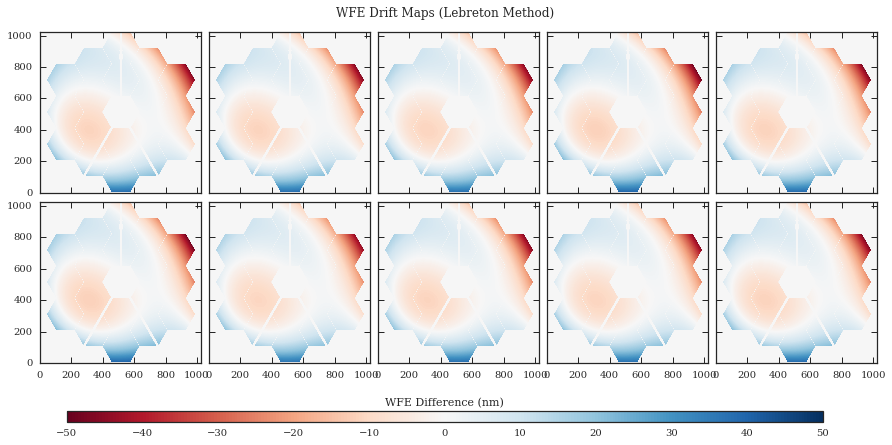

In [68]:
vlim = 50
fig, axes = plt.subplots(2,5,figsize=(15,6.2))

for i,ax in enumerate(axes.flat):
    im = ax.imshow((opd_sci_list[i]-opd_ref_list[i])*1000, cmap='RdBu', vmin=-vlim, vmax=vlim)
    ax.set_aspect('equal')
    if i % 5 > 0: ax.set_yticklabels([])
    if i < 5: ax.set_xticklabels([])

#fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.925, bottom=0.18)

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.025])
fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal')
cbar_ax.set_xlabel('WFE Difference (nm)')
cbar_ax.xaxis.set_label_position('top');

outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
fig.suptitle('WFE Drift Maps (Lebreton Method)')
#fig.savefig(outdir+'wfe_diff_10nm_lebreton.pdf')

## Science OPDs and PSFs

In [33]:
# Generate list of science OPDs and residuals for use in reference drift.
pool = mp.Pool(nproc)
%time output = pool.map(opd_sci_gen, opds_all)
opd_sci_list, opd_resid_list = zip(*output)
pool.close()
pool.join()

CPU times: user 2.39 s, sys: 3.87 s, total: 6.26 s
Wall time: 13.3 s


In [34]:
# Filters and masks
filt_coron, mask, pupil = ('F335M', 'MASK335R','CIRCLYOT') # Coronagraphic observations
filt_direct = 'F323N' # Direct Imaging

In [35]:
# Get all planet and stellar PSFs for coronagraphic observations
%time psf_sci_all = [get_psf_sci(opd, filt_coron, mask, pupil) for opd in opd_sci_list]

CPU times: user 22.9 s, sys: 13 s, total: 35.9 s
Wall time: 8min 52s


In [36]:
# Get all planet and stellar PSFs for direct imaging
%time psf_sci_direct = [get_psf_sci(opd, filt_direct, None, None) for opd in opd_sci_list]

CPU times: user 6.97 s, sys: 2.73 s, total: 9.7 s
Wall time: 25.4 s


## Drift OPDs and Reference PSFs

In [70]:
# For a series of WFE drift values:
#   - Generate a new set of OPDs
#   - Generate a new set of reference PSFs
#   - Calculate the contrast
drift_list = [1.0,2.0,5.0,10.0]
args = (opds_all, pup_cf_std, seg_cf_std, opd_resid_list) # Arguments to pass

In [71]:
# OPDs for all four drift values (10x4)
%time opd_ref_list_all = [ODP_drift_all(wfe_drift, *args) for wfe_drift in drift_list]

Finished: 1 nm
Finished: 2 nm
Finished: 5 nm
Finished: 10 nm
CPU times: user 8.88 s, sys: 14.8 s, total: 23.7 s
Wall time: 41.4 s


In [76]:
# Coronagraphic contrast
%time contrast_spot = [contrast_drift(wfe_drift, psf_sci_all, filt_coron, mask, pupil, opd_ref_list_all[i], \
                                      *args) for i,wfe_drift in enumerate(drift_list)]

Finished: 1 nm
Finished: 2 nm
Finished: 5 nm
Finished: 10 nm
CPU times: user 1min 29s, sys: 28.5 s, total: 1min 58s
Wall time: 25min 16s


In [77]:
# Direct imaging contrast
%time contrast_direct = [contrast_drift(wfe_drift, psf_sci_direct, filt_direct, None, None, opd_ref_list_all[i], \
                                        *args) for i,wfe_drift in enumerate(drift_list)]

Finished: 1 nm
Finished: 2 nm
Finished: 5 nm
Finished: 10 nm
CPU times: user 1min 10s, sys: 14.1 s, total: 1min 24s
Wall time: 2min 25s


## Plot Contrast Curves

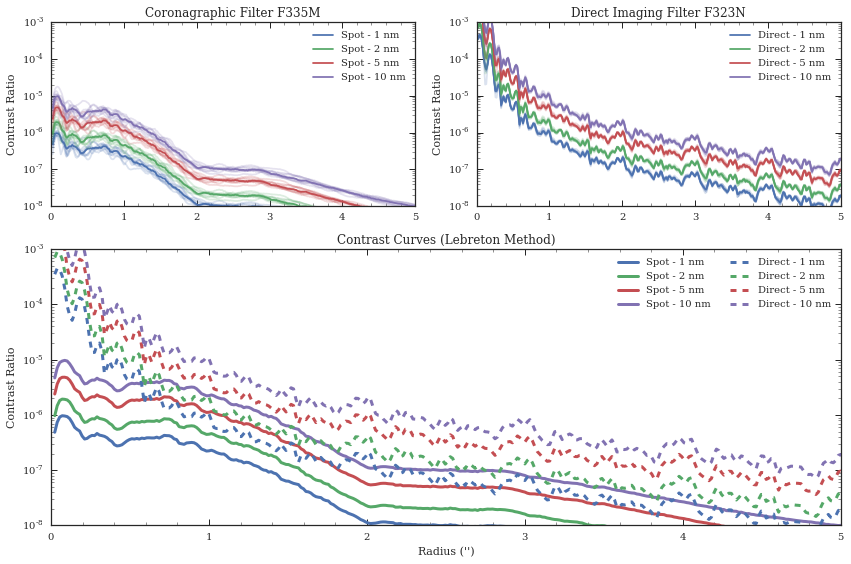

In [87]:
#f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,3))
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2,3])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, :])

current_palette = sns.color_palette()
pal1 = sns.color_palette("deep")
pal2 = sns.color_palette("muted")

for j,drift in enumerate(drift_list):
    contrast = contrast_spot[j]
    r,c = zip(*contrast_spot[j])
    med = np.median(c, axis=0)
   
    for rc in contrast:
        ax1.semilogy(rc[0], rc[1], color=current_palette[j], alpha=0.2)
    ax1.semilogy(r[0], med, color=pal1[j], label='Spot - {:.0f} nm'.format(drift))
    ax3.semilogy(r[0], med, color=pal1[j], label='Spot - {:.0f} nm'.format(drift), lw=3)

for j,drift in enumerate(drift_list):
    contrast2 = contrast_direct[j]
    r2,c2 = zip(*contrast_direct[j])
    med2 = np.median(c2, axis=0)

    for rc in contrast2:
        ax2.semilogy(rc[0], rc[1], color=current_palette[j], alpha=0.2)
    ax2.semilogy(r2[0], med2, color=pal1[j], label='Direct - {:.0f} nm'.format(drift))
    ax3.semilogy(r2[0], med2, color=pal1[j], label='Direct - {:.0f} nm'.format(drift), lw=3, ls='--')

for ax in (ax1,ax2,ax3):
    ax.legend()
    ax.set_xlim([0,5]);
    ax.set_ylim([1e-8,1e-3]);
    ax.set_ylabel('Contrast Ratio')
    ax.minorticks_on()
    #ax.set_axis_bgcolor('blue')
ax3.legend(ncol=2)
ax3.set_xlabel("Radius ('')")

ax1.set_title('Coronagraphic Filter ' + filt_coron)
ax2.set_title('Direct Imaging Filter ' + filt_direct)
ax3.set_title('Contrast Curves (Lebreton Method)')

fig.tight_layout()
outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
#fig.savefig(outdir+filt_coron+'_contrast_lebreton.pdf', facecolor='none')

In [13]:
# WFE drift for reference star

# Pupil
#coeff_pupil_new = opd_object.coeff_pupil + delta_coeff[:pup_var.size]
#opd_pupil_new = opd_object._opd_from_coeff(coeff_pupil_new, opd_object.basis_zernike, mask_pupil) * mask_pupil

# Segments
#coeff_segs_new = [cf + delta_coeff[pup_var.size:] for cf in opd_object.coeff_segs]
#opd_segs_new_list = opd_object._get_opd_new_segs(coeff_segs_new)
#opd_segs_new = opd_object.combine_opd_segs(opd_segs_new_list) * mask_pupil

# Total
#opd_ref = opd_pupil_new + opd_segs_new + opd_resid

In [ ]:
rad_all, con_all = zip(*res_all)

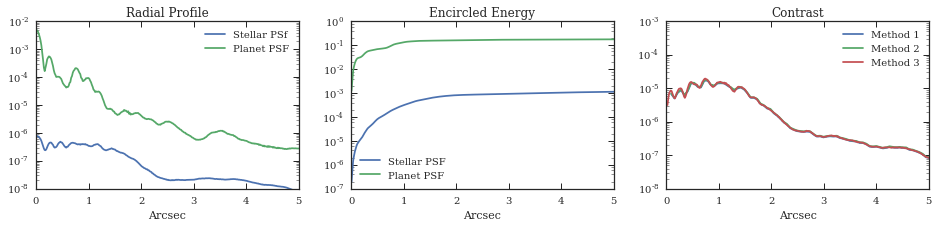

In [58]:
f, axes= plt.subplots(1,3, figsize=[16,3])
(ax1,ax2,ax3) = axes

# PSF profiles for star and planet PSFs (occulted and unocculted)
# Plot both resolutions (pixel-sampled and 4x oversampled)
ax1.semilogy(rr0, mn0*16, label='Stellar PSf')
#ax1.plot(rr1, mn1)
ax1.plot(rr_psf0, mn_psf0*16, label='Planet PSF')
#ax1.plot(rr_psf1, mn_psf1)
ax1.set_ylim([1e-8,1e-2])
ax1.set_title('Radial Profile')

# Encircled energy for star and planet PSFs
ax2.semilogy(rr0, ee0, label='Stellar PSF')
#ax2.plot(rr1, ee1)
ax2.plot(rr_psf0, ee_psf0, label='Planet PSF')
#ax2.plot(rr_psf1, ee_psf1)
ax2.set_title('Encircled Energy')

ax3.semilogy(rr1,contrast1, label='Method 1')
ax3.plot(rr1,contrast2, label='Method 2')
ax3.plot(rr0,contrast3, label='Method 3')
ax3.set_ylim([1e-8,1e-3])
ax3.set_title('Contrast')

for ax in axes:
    ax.set_xlim([0,5])
    ax.set_xlabel('Arcsec')
    ax.legend(loc=0)

In [312]:
mask0 = (opd0==0) & (opd_pupil==0) & (opd_segs==0)
mask1 = ~mask0
print('OPD RMS Variations: \n\tOriginal: {:.3f} \n\tPupil: {:.3f} \n\tSegments: {:.3f} \n\tResiduals: {:.3f}'
    .format(opd0[mask1].std(), opd_pupil[mask1].std(), opd_segs[mask1].std(), opd_resid[mask1].std()))

OPD RMS Variations: 
	Original: 0.129 
	Pupil: 0.094 
	Segments: 0.077 
	Residuals: 0.026


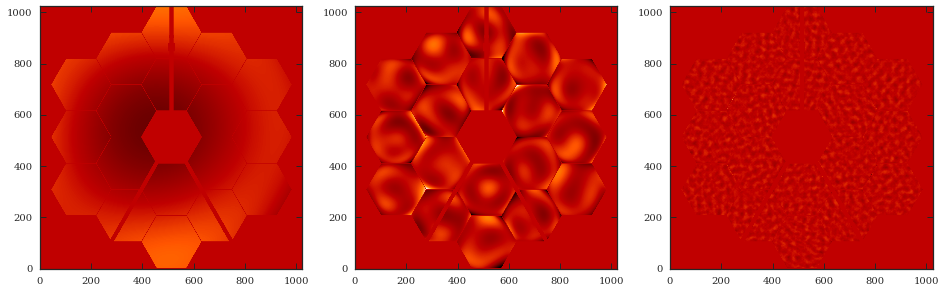

In [313]:
vlim = 0.5
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=[16,5])
ax1.imshow(opd_pupil, vmin=-vlim, vmax=vlim, cmap='gist_heat') #seg*seg_mask+
ax2.imshow(opd_segs, vmin=-vlim, vmax=vlim, cmap='gist_heat') #seg*seg_mask+
ax3.imshow(opd_resid, vmin=-vlim, vmax=vlim, cmap='gist_heat') #seg*seg_mask+

In [95]:
jopd = '/Users/jwstnircam/Desktop/JWST_SIMULATOR/PSFs/' + \
    'OPD_RevV_nircam_132_jitter_01_025_05_10_20_50_100_zernike.fits'
hdulist = fits.open(jopd)

In [100]:
noise = [0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.]
i=6
opd_new = pynrc.nrc_utils.opd_drift(opds[0,:,:], header, noise[i])
diff = opd_new[0].data - hdulist[0].data[i,:,:]

In [235]:
nterms = 8
diam = header['PUPLDIAM']
pix_m = header['PUPLSCAL']

# Create x/y carteesian grid
sh = opds.shape
if len(sh) == 3: 
    nz,ny,nx = sh
    opd_sum = opds.sum(axis=0)
    mask0 = (opd_sum == 0)
    mask1 = (opd_sum != 0)
else:
    nz = 1
    ny,nx = sh
    # Masks for those values equal (and not) to 0
    mask0 = (opds == 0)
    mask1 = (opds != 0)

y,x = np.indices((ny,nx))
center = tuple((a - 1) / 2.0 for a in [nx,ny])
y = y - center[1]; x = x - center[0]
y *= pix_m; x *= pix_m

# Convert to polar coordinates
rho = np.sqrt(x**2 + y**2) / diam
theta = np.arctan2(y,x)

# Generate Zernike maps
zall = (poppy.zernike.zernike_basis(nterms, rho=rho, theta=theta))[1:,:,:]

# Mask out defocus
zmasked = np.ma.array(zall, mask=False)
zmasked.mask[2,:,:] = True

ztot = zmasked.sum(axis=0)
#ztot = (1.0-defocus_frac)*ztot + defocus_frac*zall[2,:,:]
#ztot /= ztot.sum()
defocus_frac = 0
print(ztot.sum(),zall[2,:,:].sum())
ztot = (1.0-defocus_frac)*ztot + defocus_frac*(zall[2,:,:]/zall[2,:,:].sum())
ztot[mask0] = 0
ztot /= ztot[mask1].std()
ztot[mask1] -= ztot[mask1].mean()
print(ztot[mask1].mean(), ztot[mask1].sum(), ztot[mask1].min(), ztot[mask1].max())

4.06771505368e-10 -65.6781821415
8.63161925211e-17 5.36601874046e-11 -3.78698950884 5.02439153469


In [247]:
ztot = poppy.zernike.opd_from_zernikes([0,0,0,1,0,0,0,0], rho=rho, theta=theta, basis=poppy.zernike.zernike_basis)
ztot[mask0]=0
#ztot /= ztot[mask1].std()
print(ztot[mask1].mean(), ztot[mask1].sum(), ztot[mask1].min(), ztot[mask1].max())

-1.34732120548 -837589.173812 -1.69749324098 -0.86833628929


In [155]:
for i in range(7):
    print('{:.3f} {:.3f} {:.3f} {:.3f}'.\
            format(zall[i,:,:].mean(), zall[i,:,:].sum(), zall[i,:,:].min(), zall[i,:,:].max()))

0.000 0.000 -0.999 0.999
0.000 0.000 -0.999 0.999
-1.155 -1210791.849 -1.732 -0.003
0.000 0.000 -1.222 1.222
-0.000 -0.000 -0.611 0.611
-0.000 -0.000 -1.778 1.778
-0.000 -0.000 -1.778 1.778


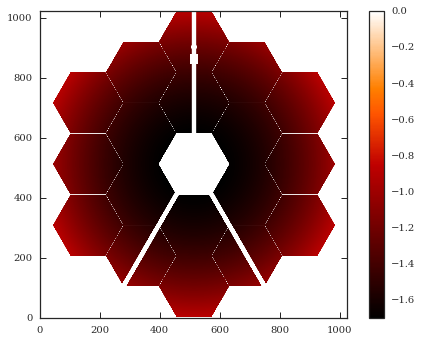

In [248]:
ax = plt.imshow(ztot, cmap='gist_heat')
plt.colorbar(ax)

In [23]:
def pix_noise_contrast(ngroup=2, nf=1, nd2=0, tf=10.737, rn=15.0, ktc=29.0, p_excess=(0,0),
    fsrc=0.0, idark=0.003, fzodi=0, fbg=0, **kwargs):
    """
    Similar to pix_noise(), except 

    Parameters
    ===========
    n (int) : Number of groups in integration ramp
    m (int) : Number of frames in each group
    s (int) : Number of dropped frames in each group
    tf (float) : Frame time
    rn (float) : Read Noise per pixel
    ktc (float) : kTC noise only valid for single frame (n=1)
    p_excess: An array or list of two elements that holding the
        parameters that describe the excess variance observed in
        effective noise plots. By default these are both 0.
        Recommended values are [1.0,5.0] or SW and [1.5,10.0] for LW.

    fsrc  (float) : Flux of source in e-/sec/pix
    idark (float) : Dark current in e-/sec/pix
    fzodi (float) : Zodiacal light emission in e-/sec/pix
    fbg   (float) : Any additional background (telescope emission or scattered light?)

    Various parameters can either be single values or numpy arrays.
    If multiple inputs are arrays, make sure their array sizes match.
    Variables that need to have the same array sizes (or a single value):
        - n, m, s, & tf
        - rn, idark, ktc, fsrc, fzodi, & fbg

    Array broadcasting also works:
        For Example
        n = np.arange(50)+1 # An array of groups to test out

        # Create 2D Gaussian PSF with FWHM = 3 pix
        npix = 20 # Number of pixels in x and y direction
        x = np.arange(0, npix, 1, dtype=float)
        y = x[:,np.newaxis]
        x0 = y0 = npix // 2 # Center position
        fwhm = 3.0
        fsrc = np.exp(-4*np.log(2.) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
        fsrc /= fsrc.max()
        fsrc *= 10 # Total source counts/sec (arbitrarily scaled)
        fsrc = fsrc.reshape(npix,npix,1) # Necessary for broadcasting

        # Represents pixel array w/ different RN/pix
        rn = np.ones([npix,npix,1])*15. 
        # Results is a (20x20)x50 showing the noise in e-/sec/pix at each group
        noise = pix_noise(ngroup=n, rn=rn, fsrc=fsrc) 
    """

    n = np.array(ngroup)
    m = np.array(nf)
    s = np.array(nd2)
    tf = np.array(tf)
    max_size = np.max([n.size,m.size,s.size,tf.size])
    if n.size  != max_size: n  = n.repeat(max_size)
    if m.size  != max_size: m  = m.repeat(max_size)
    if s.size  != max_size: s  = s.repeat(max_size)
    if tf.size != max_size: tf = tf.repeat(max_size)

    # Total flux (e-/sec/pix)
    ftot = fsrc + idark + fzodi + fbg

    # Special case if n=1
    if (n==1).any():
        # Variance after averaging m frames
        var = ktc**2 + (rn**2 + ftot*tf) / m
        noise = np.sqrt(var) 
        noise /= tf # In terms of e-/sec

        if (n==1).all(): return noise
        noise_n1 = noise

    ind_n1 = (n==1)
    temp = np.array(rn+ktc+ftot)
    temp_bool = np.zeros(temp.shape, dtype=bool)
    ind_n1_all = (temp_bool | ind_n1)

    # Group time
    tg = tf * (m + s)

    # Read noise, group time, and frame time variances
    var_rn = rn**2      * 12.               * (n - 1.) / (m * n * (n + 1.))
    var_gp = ftot  * tg * 6. * (n**2. + 1.) * (n - 1.) / (5 * n * (n + 1.))
    var_fm = ftot  * tf * 2. * (m**2. - 1.) * (n - 1.) / (m * n * (n + 1.))

    # Functional form for excess variance above theoretical
    var_ex = 12. * (n - 1.)/(n + 1.) * p_excess[0]**2 - p_excess[1] / m**0.5

    # Variance of total signal
    var = var_rn + var_gp - var_fm + var_ex
    sig = np.sqrt(var)

    # Noise in e-/sec
    noise = sig / (tg * (n - 1))
    #print(ind_n1_all.shape,noise.shape,noise_n1.shape)
    if (n==1).any():
        noise[ind_n1_all] = noise_n1[ind_n1_all]

    # Include flat field noise
    # JWST-CALC-003894
    noise_ff = 1E-4 # Uncertainty in the flat field
    factor = 1 + noise_ff*np.sqrt(ftot)
    noise *= factor

    return noise


-179.885178952 179.885178952
-116.542105331


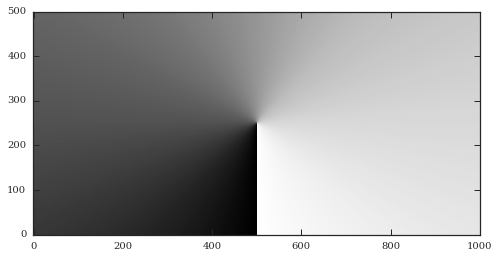

In [78]:
image = np.zeros([500,1000])
center = tuple((a - 1) / 2.0 for a in image.shape[::-1])

y,x = np.indices(image.shape)
y = y - center[1]
x = x - center[0]

r = np.sqrt(x**2 + y**2)
ang = np.arctan2(-x,y) * (180/np.pi)
print(ang.min(), ang.max())

plt.imshow(ang)
print(ang[0,999])